In [1]:
# 加载画图包
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import matplotlib.patches as mp
import seaborn as sns

# 设置全局字体
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# setting color palette
# pal = sns.color_palette("Paired")
# sns.set_palette(pal)
# sns.palplot(pal)

In [2]:
import numpy as np
import pandas as pd
import pyBigWig
import pyranges as pr
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat

# 加载画图包
from matplotlib import pyplot as plt


# get last pa sites
# get single polya site gene
last_pa_bed = '/public/home/mowp/workspace/termination/cbRNA_pool/polya_sites/cbRNA.last_polya_cluster_summit.bed'
last_pa = pr.read_bed(last_pa_bed, as_df=True)
last_pa.columns = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ratio']
last_pa.loc[:, 'Chromosome'] = last_pa.loc[:, 'Chromosome'].astype('str')

mask = last_pa.loc[:, 'Name'].str.contains('_1')
single_pa_site_gene = last_pa[mask].loc[:, 'Name'].map(lambda x: x.split('_')[0])

last_pa['Name'] = last_pa['Name'].map(lambda x: x.split('_')[0])
last_pa = last_pa.set_index(['Name'])


# get gene model
gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])


# main function

In [3]:
def get_target_site(site_type, gene_id):
    if site_type == 'PAS':
        # 获取基因PAS
        return last_pa.at[gene_id, 'End']
    elif site_type == 'aTTS':
        # 获取基因TSS
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        values = gene_model.loc[gene_id, :].values
        if values[4] == '+':
            return values[2]
        else:
            return values[1]
            
    elif site_type == 'TES':
        # 获取3' end of uncleaved readthrough
        # array(['1', 3629, 5899, '.', '+'], dtype=object)
        return int(cb_pool_read_through_len.query('gene_id == @gene_id')['tts'])
        
    else:
        raise KeyError

        
def get_cov(infile, gene_id, chrom_prefix, before, after):
    '''
    计算sites(加上上下游)区域覆盖度的频数
    '''
    chrom, start, end, _, strand = gene_model.loc[gene_id]
    if chrom in {'Pt', 'Mt'}:
        return None
    chrom = chrom_prefix+chrom
    
    pas_site = get_target_site('PAS', gene_id)  # polya site
    tts_site = get_target_site('TES', gene_id)  # median RT length 
    # atts_site = get_target_site('TES', gene_id)  # annotated TTS

    bw = pyBigWig.open(infile)
    try:
        if strand == '+':
            tts_cov = bw.values(chrom, tts_site-before, tts_site+after)
            pas_cov = bw.values(chrom, pas_site-before, pas_site+after)
            # atts_cov = bw.values(chrom, atts_site-before, atts_site+after)
        else:
            tts_cov = bw.values(chrom, tts_site-after, tts_site+before)[::-1]
            pas_cov = bw.values(chrom, pas_site-after, pas_site+before)[::-1]
            # atts_cov = bw.values(chrom, atts_site-before, atts_site+after)
    except RuntimeError:
        return
    
    tts_cov = np.nan_to_num(tts_cov)
    pas_cov = np.nan_to_num(pas_cov)
    # atts_cov = np.nan_to_num(atts_cov)
    
    sum_cov = sum(tts_cov)+sum(pas_cov)
    if sum_cov > 0:
        return pas_cov, tts_cov, gene_id

    
def get_meta_result(infile, gene_list, chrom_prefix='', before=1000, after=1000, threads=64):
    results = []
    with ProcessPoolExecutor(max_workers=threads) as e:
        chunksize = int(len(gene_list)/threads)
        results = e.map(get_cov, repeat(infile), gene_list, repeat(chrom_prefix), repeat(before), repeat(after), chunksize=chunksize)
    
    tts_cov = np.zeros(before+after)
    pas_cov = np.zeros(before+after)
    sum_cov = 0

    for res in results:
        if res is not None:
            pas_cov += res[0]
            tts_cov += res[1]
            
            sum_cov += 1
            
    return pas_cov, tts_cov, sum_cov


def metaplot(ax, cov, n, before=1000, after=1000, target_site=0, label=None, ylabel=None):
    ax.plot(cov/n, label=label)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.set_xlabel('Relative distance')
    
    ax.set_xticks([0, before, before+after])
    ax.set_xticklabels([f'-{before//1000} Kb', target_site, f'{after//1000} Kb'], rotation=90)
    
    ax.axvline(before, ls='--', color='#555555')
    if label is not None:
        ax.legend(frameon=False)

# load data

In [6]:
%store -r cb_pool_read_through_len

In [7]:
%store -r output_res

In [8]:
all_gene = set(output_res['gene_id'])

In [9]:
black_list = {'AT3G66658'}

In [10]:
output_res['label'] = pd.qcut(output_res['length'], 4, labels=["a", "b", "c", "d"])

# ChIP-seq

## BDR1 and FPA

In [12]:
treatment = '/public/home/mowp/data/public_data/bdr/bdr_GSE112443/Myc_BDR1_GSM3095567.compare.bw'
bdr1_pas_cov, bdr1_tts_cov, bdr1_sum_cov = get_meta_result(treatment, all_gene - black_list)

treatment = '/public/home/mowp/data/public_data/bdr/bdr_GSE112443/FPA_GSM3095575.compare.bw'
fpa_pas_cov, fpa_tts_cov, fpa_sum_cov = get_meta_result(treatment, all_gene - black_list)

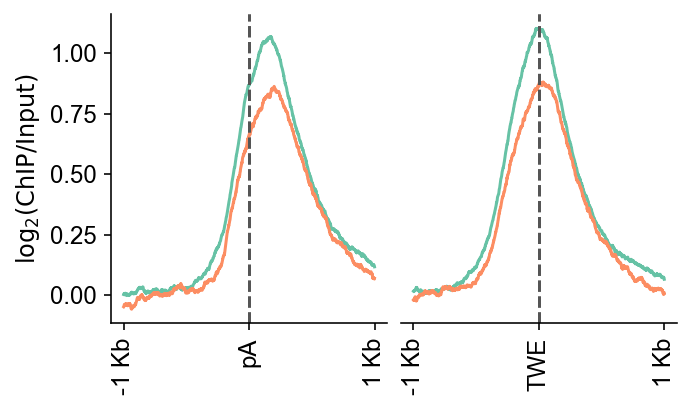

In [52]:
pal = sns.color_palette("Set2")
sns.set_palette(pal)

fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharey=True)

metaplot(ax[0], bdr1_pas_cov, bdr1_sum_cov, target_site='pA', ylabel='Normalized coverage')
metaplot(ax[1], bdr1_tts_cov, bdr1_sum_cov, target_site='TWE')

metaplot(ax[0], fpa_pas_cov, fpa_sum_cov, target_site='pA', ylabel='$\mathrm{\log_{2}{(ChIP/Input)}}$')
metaplot(ax[1], fpa_tts_cov, fpa_sum_cov, target_site='TWE')

ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_ticks_position('none')

plt.setp(ax[1].get_yticklabels(), visible=False)
plt.tight_layout()
plt.subplots_adjust(wspace=.05);

# plt.suptitle('Pol II');

### BDR1

In [17]:
a = set(output_res.query('label == "a"')['gene_id']) - black_list
b = set(output_res.query('label == "b"')['gene_id']) - black_list
c = set(output_res.query('label == "c"')['gene_id']) - black_list
d = set(output_res.query('label == "d"')['gene_id']) - black_list

In [45]:
infile = '/public/home/mowp/data/public_data/bdr/bdr_GSE112443/Myc_BDR1_GSM3095567.compare.bw'
_, a_tts_cov, a_sum_cov = get_meta_result(infile, a)
_, b_tts_cov, b_sum_cov = get_meta_result(infile, b)
_, c_tts_cov, c_sum_cov = get_meta_result(infile, c)
_, d_tts_cov, d_sum_cov = get_meta_result(infile, d)

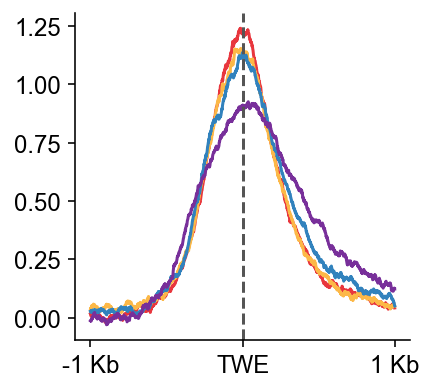

In [46]:
fig, ax = plt.subplots(1, figsize=(3, 3))

plt.plot(a_tts_cov/a_sum_cov, label='Short', color='#E8363D')
plt.plot(b_tts_cov/b_sum_cov, label='Medium', color='#FCB847')
plt.plot(c_tts_cov/c_sum_cov, label='Long', color='#3182BD')
plt.plot(d_tts_cov/d_sum_cov, label='top 25%', color='#782F9A')

# plt.legend(frameon=False, bbox_to_anchor=(1, .5, 0.5, 0.5))

ax.set_xticks([0, 1000, 2000])
ax.set_xticklabels(['-1 Kb', 'TWE', '1 Kb'])
ax.axvline(1000, ls='--', color='#555555')
# plt.ylabel('$\mathrm{\log_{2}{(ChIP/Input)}}$')

sns.despine(top=True, right=True)

### FPA

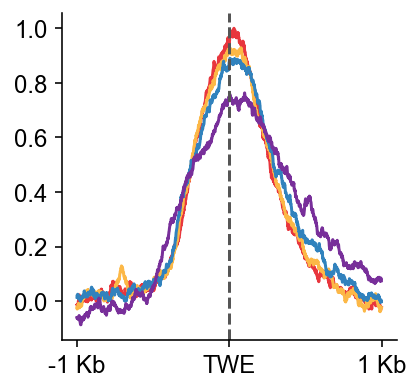

In [48]:
fig, ax = plt.subplots(1, figsize=(3, 3))

plt.plot(a_tts_cov/a_sum_cov, label='Short', color='#E8363D')
plt.plot(b_tts_cov/b_sum_cov, label='Medium', color='#FCB847')
plt.plot(c_tts_cov/c_sum_cov, label='Long', color='#3182BD')
plt.plot(d_tts_cov/d_sum_cov, label='top 25%', color='#782F9A')

# plt.legend(frameon=False, bbox_to_anchor=(.7, .5, 0.5, 0.5))

ax.set_xticks([0, 1000, 2000])
ax.set_xticklabels(['-1 Kb', 'TWE', '1 Kb'])
ax.axvline(1000, ls='--', color='#555555')
# plt.ylabel('$\mathrm{\log_{2}{(ChIP/Input)}}$')

sns.despine(top=True, right=True)

## Pol II and Ser2P

In [23]:
treatment = '/public/home/mowp/data/public_data/epigentics_data/AGO1_GSM2522247/RNAP2_rep2_GSE95301/PolII_WT_ChIP_rep2.compare.bw'
pol2_pas_cov, pol2_tts_cov, pol2_sum_cov = get_meta_result(treatment, all_gene - black_list)

treatment = '/public/home/mowp/data/public_data/epigentics_data/AGO1_GSM2522247/RNAP2_Ser2P_GSE95301/PolIISer2P_WT_ChIP.compare.bw'
ser2p_pas_cov, ser2p_tts_cov, ser2p_sum_cov = get_meta_result(treatment, all_gene - black_list)

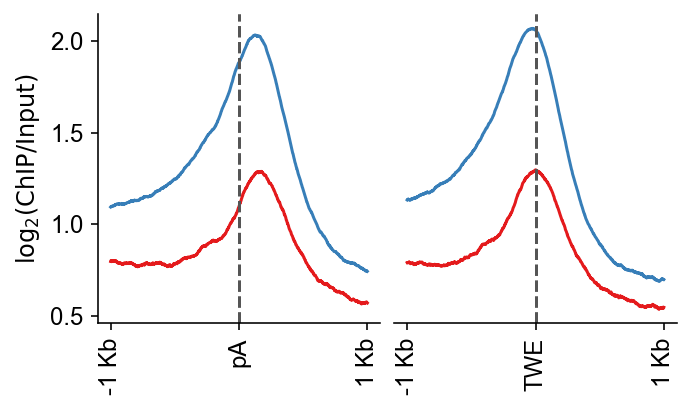

In [51]:
pal = sns.color_palette("Set1")
sns.set_palette(pal)

fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharey=True)

metaplot(ax[0], pol2_pas_cov, pol2_sum_cov, target_site='pA', ylabel='$\mathrm{\log_{2}{(ChIP/Input)}}$')
metaplot(ax[1], pol2_tts_cov, pol2_sum_cov, target_site='TWE')

metaplot(ax[0], ser2p_pas_cov, ser2p_sum_cov, target_site='pA', ylabel='$\mathrm{\log_{2}{(ChIP/Input)}}$')
metaplot(ax[1], ser2p_tts_cov, ser2p_sum_cov, target_site='TWE')

ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_ticks_position('none')

plt.setp(ax[1].get_yticklabels(), visible=False)
plt.tight_layout()
plt.subplots_adjust(wspace=.05);

# plt.suptitle('Pol II');

### Pol II

In [21]:
a = set(output_res.query('label == "a"')['gene_id']) - black_list
b = set(output_res.query('label == "b"')['gene_id']) - black_list
c = set(output_res.query('label == "c"')['gene_id']) - black_list
d = set(output_res.query('label == "d"')['gene_id']) - black_list

In [26]:
infile = '/public/home/mowp/data/public_data/epigentics_data/AGO1_GSM2522247/RNAP2_rep2_GSE95301/PolII_WT_ChIP_rep2.compare.bw'
# infile = '/public/home/mowp/data/public_data/bdr/bdr_GSE112443/RNAPII_WT_rep1_GSM3095900.compare.bw'
_, a_tts_cov, a_sum_cov = get_meta_result(infile, a)
_, b_tts_cov, b_sum_cov = get_meta_result(infile, b)
_, c_tts_cov, c_sum_cov = get_meta_result(infile, c)
_, d_tts_cov, d_sum_cov = get_meta_result(infile, d)

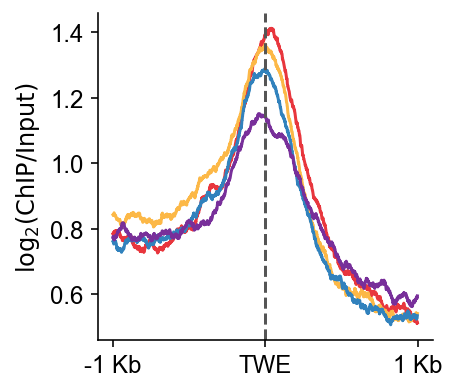

In [27]:
fig, ax = plt.subplots(1, figsize=(3, 3))

plt.plot(a_tts_cov/a_sum_cov, label='Short', color='#E8363D')
plt.plot(b_tts_cov/b_sum_cov, label='Medium', color='#FCB847')
plt.plot(c_tts_cov/c_sum_cov, label='Long', color='#3182BD')
plt.plot(d_tts_cov/d_sum_cov, label='top 25%', color='#782F9A')

# plt.legend(frameon=False, bbox_to_anchor=(1, .5, 0.5, 0.5))

ax.set_xticks([0, 1000, 2000])
ax.set_xticklabels(['-1 Kb', 'TWE', '1 Kb'])
ax.axvline(1000, ls='--', color='#555555')
plt.ylabel('$\mathrm{\log_{2}{(ChIP/Input)}}$')

sns.despine(top=True, right=True)

### Ser2P

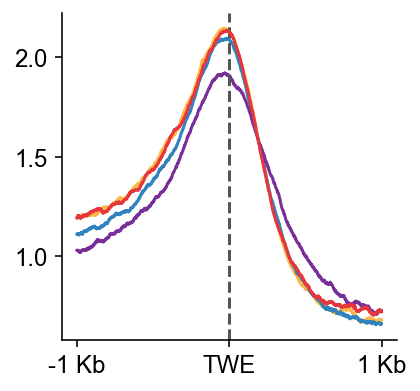

In [44]:
fig, ax = plt.subplots(1, figsize=(3, 3))

plt.plot(a_tts_cov/a_sum_cov, label='Short', color='#E8363D', zorder=10)
plt.plot(b_tts_cov/b_sum_cov, label='Medium', color='#FCB847')
plt.plot(c_tts_cov/c_sum_cov, label='Long', color='#3182BD')
plt.plot(d_tts_cov/d_sum_cov, label='top 25%', color='#782F9A')

# plt.legend(frameon=False, bbox_to_anchor=(1, .5, 0.5, 0.5))

ax.set_xticks([0, 1000, 2000])
ax.set_xticklabels(['-1 Kb', 'TWE', '1 Kb'])
ax.axvline(1000, ls='--', color='#555555')
# plt.ylabel('$\mathrm{\log_{2}{(ChIP/Input)}}$')

sns.despine(top=True, right=True)

# GRO-seq

In [58]:
treatment = '/public/home/mowp/test/GRO_seq/GRO_seq_GSE100010_NatPlant_2018/GROseq_col_rep1_GSM2667813/GROseq_col_rep1_GSM2667813.bw'
gro_pas_cov, gro_tts_cov, gro_sum_cov = get_meta_result(treatment, all_gene - black_list)

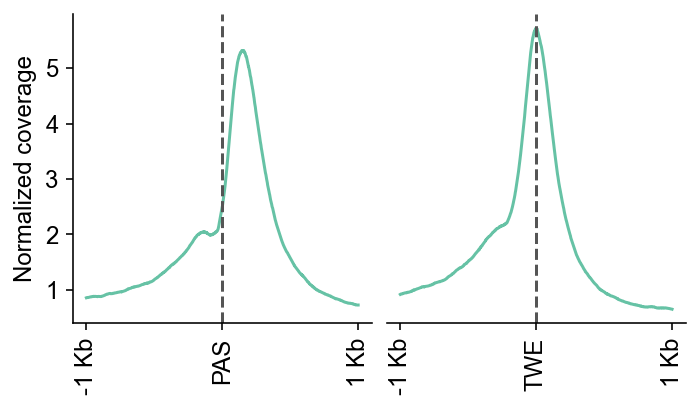

In [60]:
pal = sns.color_palette("Set2")
sns.set_palette(pal)

fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharey=True)

metaplot(ax[0], gro_pas_cov, gro_sum_cov, target_site='PAS', ylabel='Normalized coverage')
metaplot(ax[1], gro_tts_cov, gro_sum_cov, target_site='TWE',)

ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_ticks_position('none')

plt.setp(ax[1].get_yticklabels(), visible=False)
plt.tight_layout()
plt.subplots_adjust(wspace=.05);

# plt.suptitle('Pol II');

# ATAC-seq

In [54]:
treatment = '/public/home/lab-zhai/edit_share/jbrowse/tair10/Suz_chromatin_state/ATAC-SRX2000799.bw'
atac_pas_cov, atac_tts_cov, atac_sum_cov = get_meta_result(treatment, all_gene - black_list, chrom_prefix='chr')

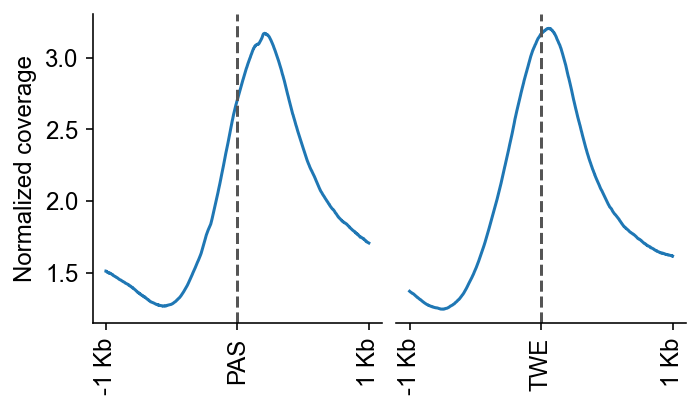

In [57]:
pal = sns.color_palette("tab10")
sns.set_palette(pal)

fig, ax = plt.subplots(1, 2, figsize=(5, 3), sharey=True)

metaplot(ax[0], atac_pas_cov, atac_sum_cov, target_site='PAS', ylabel='Normalized coverage')
metaplot(ax[1], atac_tts_cov, atac_sum_cov, target_site='TWE')

ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_ticks_position('none')

plt.setp(ax[1].get_yticklabels(), visible=False)
plt.tight_layout()
plt.subplots_adjust(wspace=.05);

# plt.suptitle('Pol II');